# FEATURE SELECTION

At this stage of the project most useful features to a model in order to predict the target variable will be selected by comparing the results of different selection methods, to both improve the performance of the model and reduce the computational cost of modelling.

## IMPORTING PACKAGES

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='white',palette='pastel')

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance


#To increase autocomplete response speed
%config IPCompleter.greedy=True

#Disabling warnings
import warnings
warnings.filterwarnings("ignore")

## DATA IMPORTATION

Replace project path.

In [4]:
project_path = (r'C:\Users\pedro\PEDRO\DS\Portfolio\LEAD_SCORING').replace('\\','/')

Names of data files.

In [5]:
df_name = 'df_input.pickle'

Data importation

In [7]:
df = pd.read_pickle(project_path + '/02_Data/03_Work/' + df_name).set_index('id')

## SUPERVISED METHODS

### Preparing x and y

In [9]:
target = 'converted'
x = df.drop(columns = target).copy()
y =  df[target].copy()

### Mutual Information

#### Creating a function to display the result

In [11]:
def ranking_mi(mutual_selector, mode = 'table'):
    #Ranking
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['feature','importance_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importance_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Displays the output
    if mode == 'table':
        return(ranking_mi)
    else:
        g = ranking_mi.importance_mi.sort_values().plot.barh(figsize = (12,20))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importance_mi').feature)
        return(g)

#### Calculating and reviewing

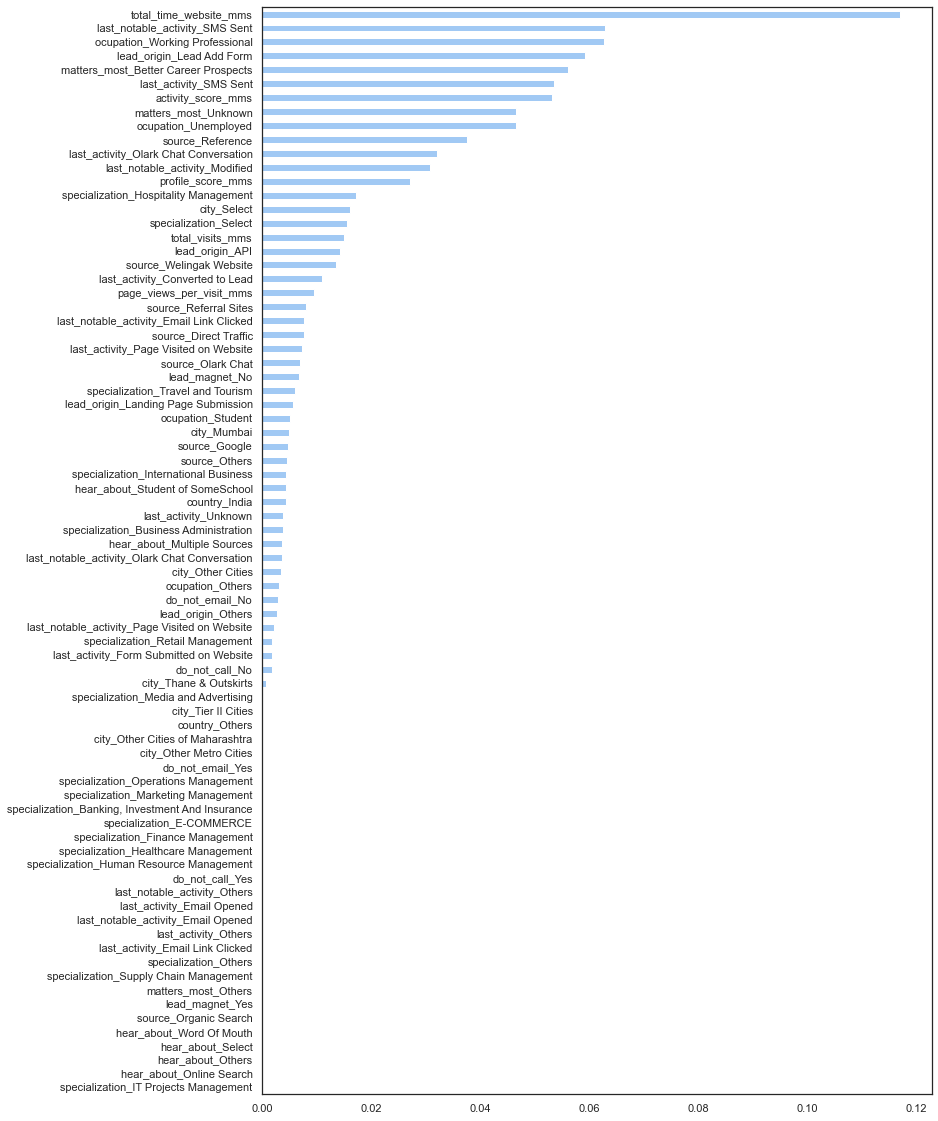

In [12]:
mutual_selector = mutual_info_classif(x,y)

rank_mi = ranking_mi(mutual_selector, mode = 'grafico')

#### Selecting features

##### Defining the position of the last variable to be selected

In [13]:
feature_limit_position = 49

##### Extracting names of selected features

In [14]:
selected_mi = ranking_mi(mutual_selector).iloc[0:feature_limit_position].feature

##### Creating dataframe with selected features

In [16]:
x_mi = x[selected_mi].copy()

### Recursive Feature Elimination

#### Instantiating

In [19]:
rfe = RFE(estimator = XGBClassifier(use_label_encoder=False, 
                                    n_jobs = -1, 
                                    eval_metric='auc'))

#### Training

In [20]:
rfe.fit(x,y)

RFE(estimator=XGBClassifier(base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, enable_categorical=False,
                            eval_metric='auc', gamma=None, gpu_id=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_delta_step=None,
                            max_depth=None, min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=-1, num_parallel_tree=None, predictor=None,
                            random_state=None, reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=None, subsample=None,
                            tree_method=None, use_label_encoder=False,
                            validate_parameters=None, verbosity=None))

In [127]:
pd.DataFrame({'features':x.columns.to_list(),
              'ranking_rfe':rfe.ranking_}).sort_values(by='ranking_rfe')

,features,ranking_rfe
0,lead_origin_API,1
34,city_Mumbai,1
35,city_Other Cities,1
76,activity_score_mms,1
42,specialization_Business Administration,1
...,...,...
72,lead_magnet_Yes,36
69,matters_most_Others,37
33,country_Others,38
28,last_notable_activity_Olark Chat Conversation,39


##### Extracting names of selected features

In [58]:
selected_rfe = x.columns[rfe.support_]

#### Crear el dataframe con la selección

In [59]:
x_rfe = x[selected_rfe].copy()

### Permutation Importance

#### Creating a function to display the result

In [60]:
def ranking_per(features,permutation):
    ranking_per = pd.DataFrame({'feature': features.columns, 'importance_per': permutation.importances_mean}).sort_values(by = 'importance_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

#### Instantiating and training

In [61]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

xgb = XGBClassifier(use_label_encoder=False, n_jobs = -1, eval_metric='auc')

xgb.fit(x,y)

permutation = permutation_importance(xgb, 
                                     x, y, 
                                     scoring = 'roc_auc',
                                     n_repeats=5, n_jobs = -1)

#### Reviewing the output

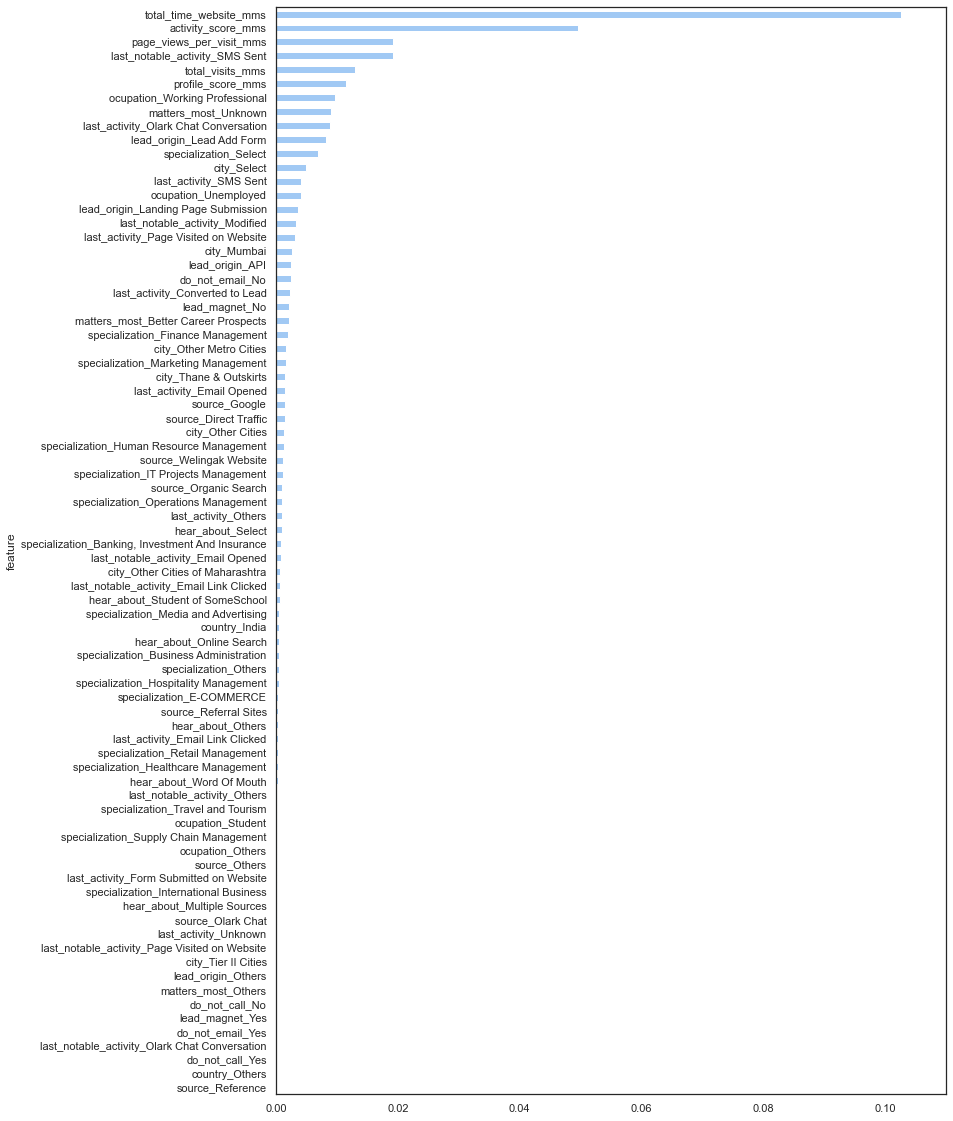

In [68]:
rank_per = ranking_per(x,permutation)

rank_per.set_index('feature').importance_per.sort_values().plot.barh(figsize = (12,20))
plt.xlim([0,0.11]);

#### Selecting features

##### Defining the position of the last variable to be selected

In [71]:
feature_limit_position = 50

##### Extracting names of selected features

In [72]:
selected_per = rank_per.iloc[0:feature_limit_position].feature

##### Creating dataframe with selected features

In [74]:
x_per = x[selected_per].copy()

## SELECTING FINAL METHOD

The results provided by the feature selection methods analysed are similar in terms of the number and features selected.

Features selected by mutual information method are taken as a basis since features such as 'source_Reference' or 'source_Olark Chat' are being taken into account, which could be predictives as discussed in the exploratory data analysis and unsupervised customer segmentation stages.

- Features selected by mutual information method but not by recursive feature elimination method:

In [244]:
x_mi.columns[~x_mi.columns.isin(x_rfe.columns)].to_list()

['source_Reference',
 'specialization_Hospitality Management',
 'source_Referral Sites',
 'last_notable_activity_Email Link Clicked',
 'source_Olark Chat',
 'specialization_Travel and Tourism',
 'ocupation_Student',
 'source_Google',
 'source_Others',
 'specialization_International Business',
 'country_India',
 'last_activity_Unknown',
 'hear_about_Multiple Sources',
 'last_notable_activity_Olark Chat Conversation',
 'ocupation_Others',
 'lead_origin_Others',
 'last_notable_activity_Page Visited on Website',
 'last_activity_Form Submitted on Website',
 'do_not_call_No',
 'city_Thane & Outskirts']

- Features selected by mutual information method but not by permutation importance method:

In [245]:
x_mi.columns[~x_mi.columns.isin(x_per.columns)].to_list()

['source_Reference',
 'source_Referral Sites',
 'source_Olark Chat',
 'specialization_Travel and Tourism',
 'ocupation_Student',
 'source_Others',
 'specialization_International Business',
 'last_activity_Unknown',
 'hear_about_Multiple Sources',
 'last_notable_activity_Olark Chat Conversation',
 'ocupation_Others',
 'lead_origin_Others',
 'last_notable_activity_Page Visited on Website',
 'specialization_Retail Management',
 'last_activity_Form Submitted on Website',
 'do_not_call_No']

In [33]:
x_preselected = x_mi

However, the following features are not being selected by mutual information method, but both by recursive feature elimination and permutation importance methods (may also have predictive capabilities), so these features will therefore be included in the initial pool of selected features.

In [108]:
(x_per.columns[(x_per.columns.isin(x_rfe.columns))]
     [~x_per.columns[(x_per.columns.isin(x_rfe.columns))].isin(x_mi.columns)]
     .to_list())

['specialization_Finance Management',
 'specialization_Marketing Management',
 'last_activity_Email Opened',
 'specialization_Human Resource Management',
 'specialization_IT Projects Management',
 'specialization_Operations Management',
 'last_activity_Others',
 'hear_about_Select']

In [230]:
x_preselected = pd.concat([x_mi, x[['specialization_Finance Management',
                                    'specialization_Marketing Management',
                                    'last_activity_Email Opened',
                                    'specialization_Human Resource Management',
                                    'specialization_IT Projects Management',
                                    'specialization_Operations Management',
                                    'last_activity_Others',
                                    'hear_about_Select']]], axis=1)

## UNSUPERVISED METHODS

The set of pre-selected features is tested for significant correlations, as the algorithm to be used has not yet been decided at this stage of the project. The existence of strong correlations, while not a drawback for tree-based algorithms, may reduce the performance of other algorithms such as logistic regressions, etc.

A compromise is therefore sought between the predictive ability of each feature and the number and importance of its correlations with other pre-selected features.

### Correlation

#### Creating a function to display the result

In [218]:
def corr_strong(dataframe, lower_lim=0.3, upper_lim=1, drop_duplicates=True):
    c = dataframe.corr().unstack().to_frame().reset_index().rename(columns={'level_0':'var_0',
                                                                            'level_1':'var_1',
                                                                            0:'corr'})
    c['corr_sign'] = np.where(c['corr']>=0,'+','-')
    c['corr'] = c['corr'].transform(abs)
    c = c.rename(columns={'corr':'corr_abs'})
    
    condition = (c['corr_abs']>lower_lim) & (c['corr_abs']<upper_lim)
    c = c.loc[condition,:].sort_values(by='corr_abs',ascending=False)
    
    c = c if drop_duplicates==False else c.drop_duplicates(subset=['corr_abs'])
    return(c)

#### Calculating and reviewing

##### Calculating

In [219]:
corr_finals = corr_strong(x_preselected)

##### Reviewing aggregate

In [221]:
corr_finals.var_1.value_counts()

lead_origin_Landing Page Submission              8
lead_origin_API                                  8
city_Select                                      7
page_views_per_visit_mms                         5
specialization_Select                            5
source_Olark Chat                                4
hear_about_Select                                4
total_visits_mms                                 3
lead_magnet_No                                   3
source_Google                                    2
city_Mumbai                                      2
source_Reference                                 2
last_activity_SMS Sent                           2
ocupation_Unemployed                             2
profile_score_mms                                2
lead_origin_Lead Add Form                        2
last_notable_activity_Modified                   2
source_Direct Traffic                            2
total_time_website_mms                           1
last_activity_Unknown          

##### Reviewing details

In [222]:
corr_finals.head(50)

,var_0,var_1,corr_abs,corr_sign
403,matters_most_Unknown,matters_most_Better Career Prospects,0.998966,-
180,lead_origin_Lead Add Form,source_Reference,0.861562,+
122,ocupation_Working Professional,ocupation_Unemployed,0.858182,-
62,last_notable_activity_SMS Sent,last_activity_SMS Sent,0.856914,+
869,specialization_Select,city_Select,0.848917,+
997,lead_origin_API,lead_origin_Landing Page Submission,0.844346,-
826,city_Select,lead_origin_Landing Page Submission,0.800019,-
815,city_Select,lead_origin_API,0.744844,+
883,specialization_Select,lead_origin_Landing Page Submission,0.743499,-
872,specialization_Select,lead_origin_API,0.736187,+


#### Filtering features

Listing the variables to be discarded due to high correlation values and eliminating them.

In [231]:
to_delete_corr = ['lead_origin_Landing Page Submission',
                  'lead_origin_API',
                  'city_Select',
                  'specialization_Select',
                  'hear_about_Select',
                  'lead_origin_Others',
                  'matters_most_Unknown',
                  'last_notable_activity_Olark Chat Conversation',
                  'last_notable_activity_Page Visited on Website',
                  ]

In [232]:
x_preselected.drop(columns = to_delete_corr, inplace = True)

Final list of selected features on which to develop the predictive model:

In [233]:
x_preselected.columns.sort_values().to_list()

['activity_score_mms',
 'city_Mumbai',
 'city_Other Cities',
 'city_Thane & Outskirts',
 'country_India',
 'do_not_call_No',
 'do_not_email_No',
 'hear_about_Multiple Sources',
 'hear_about_Student of SomeSchool',
 'last_activity_Converted to Lead',
 'last_activity_Email Opened',
 'last_activity_Form Submitted on Website',
 'last_activity_Olark Chat Conversation',
 'last_activity_Others',
 'last_activity_Page Visited on Website',
 'last_activity_SMS Sent',
 'last_activity_Unknown',
 'last_notable_activity_Email Link Clicked',
 'last_notable_activity_Modified',
 'last_notable_activity_SMS Sent',
 'lead_magnet_No',
 'lead_origin_Lead Add Form',
 'matters_most_Better Career Prospects',
 'ocupation_Others',
 'ocupation_Student',
 'ocupation_Unemployed',
 'ocupation_Working Professional',
 'page_views_per_visit_mms',
 'profile_score_mms',
 'source_Direct Traffic',
 'source_Google',
 'source_Olark Chat',
 'source_Others',
 'source_Reference',
 'source_Referral Sites',
 'source_Welingak Websi

## SAVING DATASETS AFTER FEATURE SELECTION

In [240]:
#Defining dataset names
name_x_preselected = project_path + '/02_Data/03_Work/' + 'x_preselected.pickle'
name_y_preselected = project_path + '/02_Data/03_Work/' + 'y_preselected.pickle'

In [241]:
#Saving datasets
x_preselected.to_pickle(name_x_preselected)

y_preselected = y.copy()
y_preselected.to_pickle(name_y_preselected)

In [242]:
#Saving names of the finally selected features
names_final_features = project_path + '/05_Results/' + 'final_features.pickle'

x_preselected.iloc[0].to_pickle(names_final_features)